In [1]:
import os
import re
import glob
import warnings
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import shapely
import cartopy as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import geopandas as gpd
import shapely
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [2]:
# configure data path
current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")

data_path = os.path.normpath(data_path)

In [3]:
print(data_path)

/home/dk/Desktop/space_weather_econ/data


In [4]:
# Read Greg's year event data

# event_100_year = pd.read_csv(os.path.join(data_path, "geoelectric_100year.csv"))
# event_100_year.head()

### Statistics of US Businesses (Employments and State GDPs)

In [5]:
def read_text_file(file):
    """This custom function reads large text/csv
    files, especially those with encoding errors due
    to compression

    """
    # check if tuple
    file_path = (
        os.path.join(data_path, file)
        if isinstance(file, str)
        else os.path.join(data_path, *file)
    )

    with open(file_path, encoding="utf-8", errors="ignore") as file:
        content = file.read()

    content_io = StringIO(content)
    return pd.read_csv(content_io, low_memory=False)

In [6]:
# load GDP data
gdp_state = read_text_file(("SAGDP", "SAGDP1__ALL_AREAS_2017_2022.csv"))

# use gdp data (millions of chained 2017 dollars dollars)
state_2022 = gdp_state[
    gdp_state.Description == "Real GDP (millions of chained 2017 dollars) 1/"
]
state_2022.loc[:, "STATE"] = state_2022.GeoFIPS.apply(lambda fips: int(fips[2:4]))

# load the NAICS data
us_states_details_naics = read_text_file("us_state_naics_detailedsizes_2020.txt")

# extract the total employments in each entersize per state
state_empl = us_states_details_naics[
    (us_states_details_naics.ENTRSIZE == 1)
    & (us_states_details_naics.NAICSDSCR == "Total")
]
state_empl_reset = state_empl.reset_index(drop=True)

# load the 2020 state population data
pop_data = pd.read_csv(os.path.join(data_path, "pop_2020_state.csv"))

# join the three datasets
state_gdp_empl_pop = state_empl_reset.merge(
    state_2022[["2022", "STATE"]], on="STATE"
).merge(pop_data, on="STATE")
state_gdp_empl_pop.rename(
    columns={"2022": "2022REALGDP", "POPULATION": "STPOP", "stab": "STABBR"},
    inplace=True,
)
state_gdp_empl_pop.drop("STATE", axis=1, inplace=True)


# free some memory
del gdp_state
del state_empl
# del us_states_details_naics
# del content_io
del state_empl_reset
del state_2022

state_gdp_empl_pop.head(5)

,NAICS,ENTRSIZE,FIRM,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STABBR,STPOP
0,--,1,74850,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,AL,5024279
1,--,1,17169,21184,266063,G,16331033,G,Alaska,Total,01: Total,50315.1,AK,733391
2,--,1,116423,149829,2644781,G,134085208,G,Arizona,Total,01: Total,403474.2,AZ,7151502
3,--,1,51451,67586,1055534,G,47494746,G,Arkansas,Total,01: Total,137355.5,AR,3011524
4,--,1,805423,981369,15710859,G,1132425660,G,California,Total,01: Total,3167460.8,CA,39538223


In [7]:
state_empl = us_states_details_naics[
    (us_states_details_naics.ENTRSIZE == 1)
    & (us_states_details_naics.NAICSDSCR == "Total")
]

### US. Electricity Transmission Operators

In [8]:
# Load your shapefile into a GeoDataFrame
rto_gdf = gpd.read_file(
    os.path.join(data_path, "NERC Map", "electricity_operators.shp")
)

# Check for overlaps by performing a spatial join with itself
overlaps = gpd.sjoin(rto_gdf, rto_gdf, how="inner", predicate="intersects")
overlaps = overlaps[overlaps["id_left"] != overlaps["id_right"]]

nerc_gdf = rto_gdf.copy()

# Subtract the geometries of overlapping inner polygons from their outer polygons
for _, row in overlaps.iterrows():
    outer_geom = nerc_gdf.loc[nerc_gdf["id"] == row["id_left"], "geometry"].iloc[0]
    inner_geom = nerc_gdf.loc[nerc_gdf["id"] == row["id_right"], "geometry"].iloc[0]
    if inner_geom.within(outer_geom):
        nerc_gdf.loc[
            nerc_gdf["id"] == row["id_left"], "geometry"
        ] = outer_geom.difference(inner_geom)

nerc_gdf.to_crs(epsg=4326, inplace=True)

# fix the outer boundaries of the NERC df by clipping with state boundaries from USPS
# state boundaries
states = gpd.read_file(os.path.join(data_path, "tl_2022_us_state.zip"))
states.to_crs(epsg=4326, inplace=True)

# non contig states
non_cont_fips_codes = ["02", "15", "72", "66", "60", "69", "78", "78"]
states = states[~states.GEOID.isin(non_cont_fips_codes)]

# rename column id to REGION_ID
nerc_gdf.rename(columns={"id": "REGION_ID"}, inplace=True)
nerc_gdf.loc[nerc_gdf["REGION_ID"] == 23, "REGIONS"] = "ERCOT"

In [9]:
nerc_gdf.head()

,REGION_ID,REGIONS,geometry
0,1,WestConnectNonEnrolled,"POLYGON ((-114.63644 36.16374, -114.24282 36.0..."
1,2,WestConnectNonEnrolled,"POLYGON ((-111.78450 34.03263, -111.34078 34.0..."
2,3,WestConnectNonEnrolled,"POLYGON ((-111.78092 37.27375, -109.78778 37.2..."
3,4,WestConnectNonEnrolled,"POLYGON ((-108.17037 40.40928, -107.57875 40.4..."
4,5,WestConnect,"POLYGON ((-108.50435 40.22375, -108.48527 40.3..."


In [10]:
# fix the alignment of the digitized raster
utm_epsg_code = 32633
nerc_gdf_projected = nerc_gdf.to_crs(epsg=utm_epsg_code)
states_projected = states.to_crs(epsg=utm_epsg_code)

# apply buffer of 10 metres
buffer_distance = 10
nerc_gdf_buffered = nerc_gdf_projected.buffer(buffer_distance)

# create a single polygon
states_boundary = states_projected.geometry.unary_union

# make sure the coordinate systems are equal
states_boundary_gdf = gpd.GeoDataFrame(geometry=[states_boundary], crs=utm_epsg_code)

# overlay the two
aligned_nerc = gpd.overlay(
    gpd.GeoDataFrame(geometry=nerc_gdf_buffered, crs=utm_epsg_code),
    states_boundary_gdf,
    how="intersection",
)

# reproject to the previous crs
aligned_nerc = aligned_nerc.to_crs(nerc_gdf.crs)

# Update the geometry
nerc_gdf.geometry = aligned_nerc.geometry

# write nerc into a geojson file
path = os.path.join(data_path, "nerc_gdf.geojson")
nerc_gdf.to_file(path, driver="GeoJSON")

In [12]:
nerc_gdf.REGIONS.unique()

array(['WestConnectNonEnrolled', 'WestConnect', 'NorthernGridUnconnected',
       'NorthernGridConnected', 'SPP', 'MISO', 'FRCC', 'SCRTP', 'NYISO',
       'PJM', 'SERTP', 'ISONE', 'ERCOT', 'NotOrder1000', 'CAISO'],
      dtype=object)

### US Population at Census Block Levels

In [11]:
def format_tractce(tract):
    # add leading zeros if whole != 4 digits and trailing zero if decimal not 2 digits

    if type(tract) != str:
        whole, decimal = str(tract).split(".")
        # Add leading zeros to the whole number part if necessary to make it 4 digits
        whole = whole.zfill(4)
        if len(decimal) == 1:  # Check if decimal part is a single digit
            decimal += "0"  # Append a zero

        tract = f"{whole}.{decimal}"
    if type(tract) != str:
        print(tract)
    return tract.replace(".", "")

In [12]:
# load the data at block group levels
pop_bg = read_text_file("pop_2020_censu_block.csv")
pop_bg.drop(0, inplace=True)

pop_bg.rename(
    columns={
        "state": "STATEFP",
        "county": "COUNTYFP",
        "tract": "TRACTCE",
        "blockgroup": "BLKGRPCE",
        "pop20": "POP20BG",
        "afact": "AFACT",
        "stab": "STABBR",
    },
    inplace=True,
)
pop_bg["TRACTCE"] = pop_bg.TRACTCE.apply(format_tractce)

# make thus columns string
cols_to_convert = ["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]
pop_bg[cols_to_convert] = pop_bg[cols_to_convert].astype(str)

pop_bg.STATEFP = pop_bg.STATEFP.astype(str)

# remove non contigous states
pop_bg_cont = pop_bg[~pop_bg.STATEFP.isin(non_cont_fips_codes)]

# merge the population data at census block levels
block_gdp_pop = pop_bg_cont.merge(state_gdp_empl_pop, on="STABBR")
block_gdp_pop.POP20BG = block_gdp_pop.POP20BG.apply(lambda x: int(x))

# del pop_bg
# del pop_bg_cont
block_gdp_pop.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,STABBR,CountyName,POP20BG,AFACT,NAICS,ENTRSIZE,...,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP
0,01,01001,020100,1,AL,Autauga AL,575,0.0001,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
1,01,01001,020100,2,AL,Autauga AL,1200,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
2,01,01001,020200,1,AL,Autauga AL,974,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
3,01,01001,020200,2,AL,Autauga AL,1081,0.0002,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279
4,01,01001,020300,1,AL,Autauga AL,2377,0.0005,--,1,...,100955,1777495,G,81317411,G,Alabama,Total,01: Total,235807.3,5024279


In [13]:
unique_pairs = block_gdp_pop[['STABBR', '2022REALGDP']].drop_duplicates()
unique_pairs["2022REALGDP"].sum()

21534948.8

### Census Block Group Shapefiles

In [26]:
directory = "tl_bg"

file_pattern = "tl_2020_*.zip"

# Get a list of all the shapefiles in the directory matching the pattern
output_shapefile_zip = "combined_shapefile.zip"

if os.path.exists(os.path.join(data_path, output_shapefile_zip)):
    combined_gdf = gpd.read_file(
        os.path.join(data_path, output_shapefile_zip, "combined_shapefile.shp")
    )
else:
    shapefile_paths = glob.glob(os.path.join(data_path, directory, file_pattern))
    gdfs = [gpd.read_file(path) for path in shapefile_paths]
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    del gdfs
    combined_gdf.to_file(
        os.path.join(data_path, output_shapefile_zip), driver="ESRI Shapefile"
    )

In [28]:
# extract only contigous states census block gdf
cont_bg = combined_gdf[~combined_gdf.STATEFP.isin(non_cont_fips_codes)]

cont_bg["rep_points"] = cont_bg.geometry.representative_point()

# points/census blocks within NERD Transmission map
nerc_gdf = nerc_gdf.to_crs(cont_bg.crs)
points_within_rto = gpd.sjoin(
    cont_bg.set_geometry("rep_points"), nerc_gdf, how="inner", predicate="within"
)

# merge the census blocks and regional transmission op datasets
points_within_rto["COUNTYFP"] = (
    points_within_rto["STATEFP"] + points_within_rto["COUNTYFP"]
)
points_within_rto[["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]] = points_within_rto[
    ["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]
].astype(str)

# join with the census and business stats data
df = points_within_rto.merge(
    block_gdp_pop, on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]
)

df.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,ESTB,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP
0,20,20003,953600,3,200039536003,Block Group 3,G5030,S,1665923,4526,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
1,20,20003,953600,4,200039536004,Block Group 4,G5030,S,4789695,76622,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
2,20,20003,953600,1,200039536001,Block Group 1,G5030,S,329643568,2950927,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
3,20,20003,953600,2,200039536002,Block Group 2,G5030,S,1688946,1498,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880
4,20,20003,953700,2,200039537002,Block Group 2,G5030,S,388883407,2399109,...,73982,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880


In [29]:
# Analysis dataframe in R
df["BGSTATEGDP"] = df.POP20BG / df.STPOP * df["2022REALGDP"]

df_analysis = df[
    [
        "NAICS",
        "REGIONS",
        "STABBR",
        "POP20BG",
        "FIRM",
        "ESTB",
        "EMPL",
        "REGION_ID",
        "EMPLFL_N",
        "PAYR",
        "NAICSDSCR",
        "2022REALGDP",
        "STPOP",
        "BGSTATEGDP",
    ]
]

# Save the df
df_analysis.to_csv(os.path.join(data_path, "df_rto_stats.csv"), index=False)

In [30]:
df.drop("rep_points", inplace=True, axis=1)

In [31]:
# save the dataframe as a GEOJSON
df.set_geometry("geometry", inplace=True)
df.to_crs(epsg=4326)

# path = os.path.join(data_path, "block_levels_gdf")
# df.to_file(path, driver="GeoJSON")

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,EMPL,EMPLFL_N,PAYR,PAYRFL_N,STATEDSCR,NAICSDSCR,ENTRSIZEDSCR,2022REALGDP,STPOP,BGSTATEGDP
0,20,20003,953600,3,200039536003,Block Group 3,G5030,S,1665923,4526,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,42.897227
1,20,20003,953600,4,200039536004,Block Group 4,G5030,S,4789695,76622,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,101.918101
2,20,20003,953600,1,200039536001,Block Group 1,G5030,S,329643568,2950927,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,108.938729
3,20,20003,953600,2,200039536002,Block Group 2,G5030,S,1688946,1498,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,40.814838
4,20,20003,953700,2,200039537002,Block Group 2,G5030,S,388883407,2399109,...,1207003,G,58374388,G,Kansas,Total,01: Total,174794.6,2937880,55.629553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234871,13,13039,010604,3,130390106043,Block Group 3,G5030,S,2367301,14498,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,90.917840
234872,13,13039,010604,2,130390106042,Block Group 2,G5030,S,1760863,131937,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,68.142462
234873,13,13039,010603,1,130390106031,Block Group 1,G5030,S,5708433,1349157,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,81.060755
234874,13,13039,010403,3,130390104033,Block Group 3,G5030,S,12222285,838590,...,4107151,G,216568398,G,Georgia,Total,01: Total,655827.3,10711908,83.142375


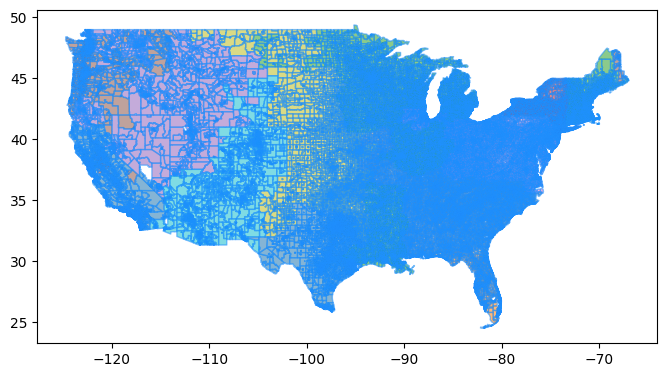

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# Plot data
df.plot(ax=ax, column="REGIONS", edgecolor="dodgerblue", alpha=0.55, legend=False)

# Stylize plots
plt.style.use("bmh")

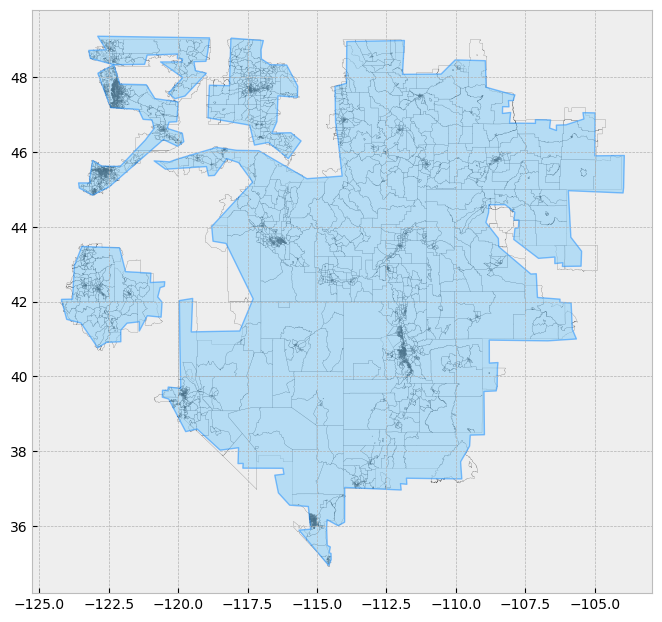

In [33]:
# Northern Grid and States
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

nttg_gdf = df[df["REGIONS"] == "NorthernGridConnected"]

# nttg census blocks
nttg_raw = combined_gdf[combined_gdf.GEOID.isin(nttg_gdf.GEOID)]

# plot census blocks with slightly thin line
nttg_gdf.plot(
    ax=ax, edgecolor="black", linewidth=0.1, facecolor="none", column="POP20BG"
)

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "NorthernGridConnected"].plot(
    ax=ax, color="lightskyblue", edgecolor="dodgerblue", alpha=0.55, linewidth=1.0
)

# Stylize plots
plt.style.use("bmh")

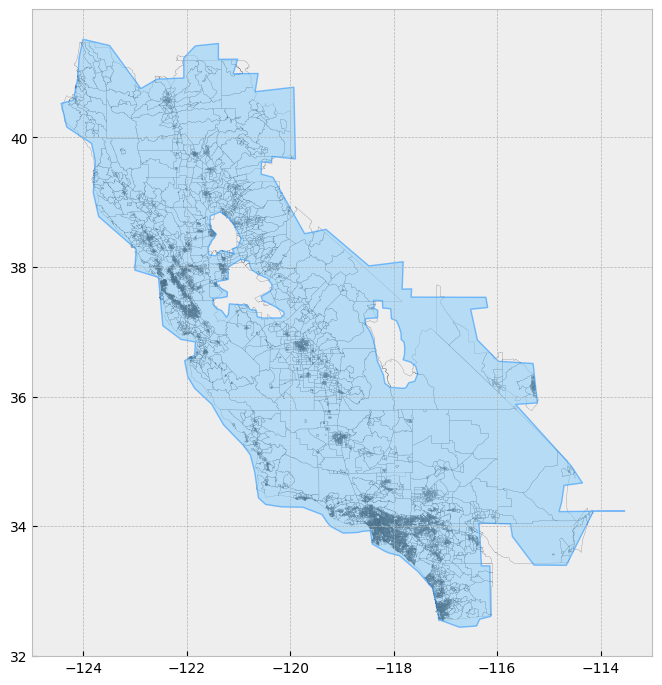

In [34]:
# CAISO and States
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

caiso_gdf = df[df["REGIONS"] == "CAISO"]
# caiso_geometry_gdf = caiso_gdf.dissolve(by='REGIONS')

# caiso census blocks
caiso_raw = combined_gdf[combined_gdf.GEOID.isin(caiso_gdf.GEOID)]

# plot census blocks with slightly thin line
caiso_raw.plot(ax=ax, edgecolor="black", linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "CAISO"].plot(
    ax=ax, color="lightskyblue", edgecolor="dodgerblue", alpha=0.55, linewidth=1.0
)

# Stylize plots
plt.style.use("bmh")

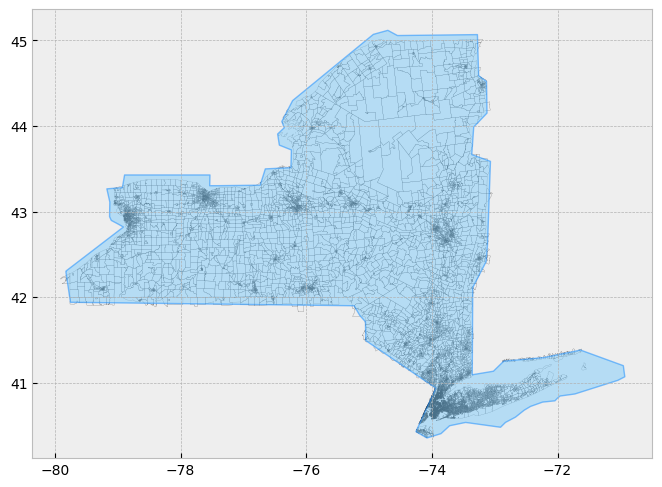

In [35]:
# NYISO and States
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

nyiso_gdf = df[df["REGIONS"] == "NYISO"]

# nyisp census blocks
nyiso_raw = combined_gdf[combined_gdf.GEOID.isin(nyiso_gdf.GEOID)]

# plot census blocks with slightly thin line
nyiso_raw.plot(ax=ax, edgecolor="black", linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "NYISO"].plot(
    ax=ax, color="lightskyblue", edgecolor="dodgerblue", alpha=0.55, linewidth=1.0
)

# Stylize plots
plt.style.use("bmh")

## Business statistics at ZCTA levels

In [119]:
# Read less detailed ZCTA businesses data
zcta_cbp_detailed = read_text_file("zbp21detail.txt")
zcta_cbp_detailed.columns = [col.upper() for col in zcta_cbp_detailed.columns]

# Calculate subsector sums
subsector_sums = (
    zcta_cbp_detailed[zcta_cbp_detailed["NAICS"].str.contains(r"\d{2}----")]
    .groupby("ZIP")["EST"]
    .sum()
)

# Identify total establishments
total_establishments = zcta_cbp_detailed[
    zcta_cbp_detailed["NAICS"] == "------"
].set_index("ZIP")["EST"]

# Calculate other establishments
other_establishments = total_establishments.sub(
    subsector_sums, fill_value=0
).reset_index()
other_establishments["NAICS"] = "UNCLFD"

# Filter and clean NAICS codes
filtered_df = zcta_cbp_detailed[
    zcta_cbp_detailed["NAICS"].str.contains(r"\b\d{2}----", na=False, regex=True)
]
filtered_df["NAICS"] = filtered_df["NAICS"].str.replace("-", "", regex=True).astype(int)

# Select required columns
filtered_ = filtered_df[["ZIP", "NAICS", "EST", "STABBR"]]

# Combine filtered DataFrame with other establishments
combined_df = pd.concat([filtered_, other_establishments[["ZIP", "NAICS", "EST"]]])
combined_df = combined_df.sort_values(by="ZIP")

In [18]:
zcta_cbp_detailed[zcta_cbp_detailed.NAICS.str.startswith("92")]

,ZIP,NAME,NAICS,EST,N<5,N5_9,N10_19,N20_49,N50_99,N100_249,N250_499,N500_999,N1000,CITY,STABBR,CTY_NAME


In [21]:
# read business data - totals
# less detail zcta businesses data
zcta_cbp_total = read_text_file("zbp21totals.txt")
zcta_cbp_total.columns = [col.upper() for col in zcta_cbp_total.columns]
zcta_cbp_total.ZIP = zcta_cbp_total.ZIP.astype(int)

zcta_cbp_total.head(3)

,ZIP,NAME,EMP_NF,EMP,QP1_NF,QP1,AP_NF,AP,EST,CITY,STABBR,CTY_NAME
0,501,"HOLTSVILLE, NY",J,41,J,198,J,898,10,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",G,7616,G,103920,G,447397,475,AGAWAM,MA,HAMPDEN
2,1002,"AMHERST, MA",H,7450,H,70191,H,315640,502,AMHERST,MA,HAMPSHIRE


In [23]:
# load the zcta shapefiles
zcta_gdf = gpd.read_file(os.path.join(data_path, "tl_2020_us_zcta520.zip"))
zcta_gdf.rename(columns={"ZCTA5CE20": "ZCTA"}, inplace=True)
zcta_gdf.ZCTA = zcta_gdf.ZCTA.astype(int)

# as a representative point
zcta_gdf["representative_point"] = zcta_gdf.geometry.representative_point()

In [24]:
# zctas within NERD Transmission map
nerc_gdf = nerc_gdf.to_crs(zcta_gdf.crs)

zcta_within_rto = gpd.sjoin(
    zcta_gdf.set_geometry("representative_point"),
    nerc_gdf,
    how="inner",
    predicate="within",
)

zcta_within_rto.columns = [col.upper() for col in zcta_within_rto.columns]
zcta_within_rto.head(3)

,ZCTA,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,GEOMETRY,REPRESENTATIVE_POINT,INDEX_RIGHT,REGION_ID,REGIONS
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654...",POINT (-88.08956 33.74089),20,21,SERTP
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582...",POINT (-87.98437 34.74181),20,21,SERTP
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349...",POINT (-86.73471 34.35011),20,21,SERTP


In [26]:
# load the population at the zcta level
zcta_pop_20 = read_text_file("pop_2020_zcta.csv")

# drop the first row
zcta_pop_20.drop(0, inplace=True)
zcta_pop_20.reset_index(inplace=True, drop=True)

zcta_pop_20["zcta"] = zcta_pop_20.zcta.str.strip()
zcta_pop_20 = zcta_pop_20[zcta_pop_20["zcta"] != ""]
zcta_pop_20[["zcta", "pop20"]] = zcta_pop_20[["zcta", "pop20"]].astype(int)

zcta_pop_20.columns = [col.upper() for col in zcta_pop_20.columns]
zcta_pop_20.rename(columns={"STAB": "STABBR"}, inplace=True)
zcta_pop_20.head(3)

# save the population data
zcta_pop_20.to_csv(os.path.join(data_path, "2020_decennial_census_at_ZCTA_level.csv"), index=False)

In [27]:
# read zcta zip concordance data
zcta_zip_df = pd.read_excel(
    os.path.join(data_path, "ZIPCodetoZCTACrosswalk2021UDS.xlsx")
)
zz_not_na = zcta_zip_df[~zcta_zip_df.ZCTA.isna()]
zz_not_na.ZCTA = zz_not_na.ZCTA.astype(int)

zz_not_na.rename(columns={"ZIP_CODE": "ZIP", "STATE": "STABBR"}, inplace=True)
zz_not_na.head(3)

,ZIP,PO_NAME,STABBR,ZIP_TYPE,ZCTA,zip_join_type
0,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
1,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
2,601,Adjuntas,PR,Zip Code Area,601,Zip matches ZCTA


In [28]:
# Merging detailed business data with ZCTA count data
zz_dtld = combined_df.merge(
    zz_not_na[["STABBR", "ZIP", "PO_NAME", "ZCTA"]], on="ZIP", how="left"
)

# Dropping the duplicate 'STABBR_x' column
zz_dtld.drop("STABBR_x", axis=1, inplace=True)

# Renaming 'STABBR_y' to 'STABBR'
zz_dtld.rename(columns={"STABBR_y": "STABBR"}, inplace=True)

# Grouping by ZCTA, NAICS, and STABBR and summing the EST values
df_naics_zcta = zz_dtld.groupby(["ZCTA", "NAICS", "STABBR"])["EST"].sum().reset_index()

In [29]:
# merge the population, and business dataset with the zctas within rtos
df_naics_regions = df_naics_zcta.merge(zcta_within_rto[["REGIONS", "ZCTA"]], on="ZCTA")

# drop the government services in the NAICS
naics_wo_govt = df_naics_regions[df_naics_regions.NAICS != 99]

In [35]:
GDP_DIR = os.path.join(data_path, "SAGDP")
state_gdp_files = os.listdir(GDP_DIR)
STATES = df_naics_regions.STABBR.unique()
pattern = r"^\d{2}$|^\d{2}-\d{2}$"

state_data = {}

for file in state_gdp_files:
    state_abbr, file_type = file.split("_")[1], file.split("_")[0]
    if state_abbr in STATES and file_type == "SAGDP9N":  # Check for current GDP files
        # Read the state GDP file
        state_gdp_file = os.path.join(GDP_DIR, file)
        df_gdp = pd.read_csv(state_gdp_file)
        df_gdp["STABBR"] = state_abbr

        # Filter rows matching the pattern
        filtered_gdp = df_gdp[df_gdp["IndustryClassification"].str.match(pattern, na=False)]
        filtered_gdp["IndustryClassification"] = filtered_gdp["IndustryClassification"].str.split("-").str[0].astype(int)
        filtered_gdp.rename(columns={"IndustryClassification": "NAICS", "2022": "CGDP2022"}, inplace=True)

        # Create and add the summary row
        summary_row = {
            "NAICS": "--",
            "Description": "--",
            "CGDP2022": filtered_gdp["CGDP2022"].astype(float).sum(),
            "STABBR": state_abbr
        }
        
        filtered_gdp = pd.concat([pd.DataFrame([summary_row]), filtered_gdp], ignore_index=True)
        state_data[state_abbr] = filtered_gdp[["NAICS", "Description", "CGDP2022", "STABBR"]]

In [96]:
# Convert 'EST' to numeric
naics_wo_govt["EST"] = naics_wo_govt["EST"].apply(pd.to_numeric, errors="ignore")

# Calculate total establishments for each state
total_est = naics_wo_govt.groupby("STABBR")["EST"].sum()

# Create the state_firms dictionary
state_firms = total_est.to_dict()

# Group data by STABBR and NAICS, then sum EST
grouped_data = naics_wo_govt.groupby(["STABBR", "NAICS"])["EST"].sum()

# Create the nested dictionary
nested_dict_emp = {state: grouped_data[state].to_dict() for state in grouped_data.index.levels[0]}

# Create map_state_gdp dictionary
map_state_gdp = {state: dict(zip(state_data[state].NAICS, state_data[state].CGDP2022))
                 for state in state_data.keys()}

In [120]:
def calc_gdp(row):
    try:
        # Extracting necessary values from the row
        state, naics, est = row["STABBR"], row["NAICS"], row["EST"]
        
        # Retrieve total establishments and GDP for the NAICS code
        total_est = nested_dict_emp[state][naics]
        
        if naics == "UNCLFD":
            naics = 92

        naics_gdp = map_state_gdp[state][naics]

        # Calculate the proportionate GDP
        gdp_zcta_naic = round((float(est) / float(total_est)) * float(naics_gdp), 2)

#     except KeyError:
#         # Handle missing NAICS code by using state-level data
#         total_gdp = map_state_gdp[state]["--"]
#         total_state_firms = state_firms[state]

#         # Calculate the proportionate GDP based on state data
#         gdp_zcta_naic = round((float(est) / float(total_state_firms)) * float(total_gdp), 2)

    except TypeError as e:
        # Print error details for debugging
        print(f"TypeError encountered: {e}")
        print(f"State: {state}, NAICS: {naics}, EST: {est}, Total EST: {total_est}, NAICS GDP: {naics_gdp}")
        return np.nan

    return gdp_zcta_naic

# Apply the function to each row
naics_wo_govt["GDP2022"] = naics_wo_govt.apply(calc_gdp, axis=1)

naics_wo_govt.to_csv(os.path.join(data_path, "NAICS_EST_GDP2022_ZCTA.csv"), index=False)

In [127]:
naics_wo_govt[naics_wo_govt["STABBR"] == "CA"].groupby("NAICS")["GDP2022"].sum()

NAICS
11         30527.14
21          6557.34
22         38017.73
23        106709.79
31        349657.12
42        148894.66
44        159098.44
48         94759.11
51        416668.19
52        146129.50
53        432007.45
54        345830.15
55         56776.17
56        103328.93
61         33233.85
62        210161.62
71         44845.28
72         86852.99
81         52990.78
UNCLFD    328332.45
Name: GDP2022, dtype: float64

In [122]:
# Using business totals
# Merging ZCTA data into the business data
zz_df = zcta_cbp_total.merge(
    zz_not_na[["STABBR", "ZIP", "PO_NAME", "ZCTA"]], on=["ZIP", "STABBR"], how="left"
)

# Summing up the employment, firms, payrolls, and establishments in each ZCTA
zz_df_summed = (
    zz_df.groupby(["ZCTA", "STABBR"])[["EMP", "QP1", "AP", "EST"]].sum().reset_index()
)

# Merging population data into the summed business data
zz_pop = zz_df_summed.merge(zcta_pop_20, on=["ZCTA", "STABBR"])

# Displaying the first few rows of the merged DataFrame
zz_pop.head()

# merge the population, and business dataset with the zctas within rtos
df_zcta_total = zz_pop.merge(zcta_within_rto, on="ZCTA")

In [123]:
# df.groupby("REGIONS")[["POP20BG"]].sum().reset_index()

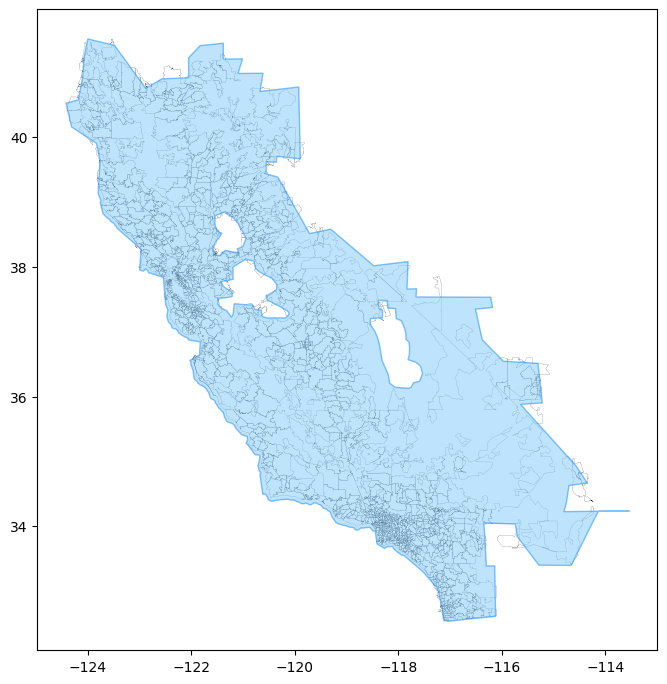

In [43]:
# CAISO and zctas
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

caiso_gdf = df_zcta_total[df_zcta_total["REGIONS"] == "CAISO"]
# caiso_geometry_gdf = caiso_gdf.dissolve(by='REGIONS')

# caiso census blocks
caiso_raw = zcta_gdf[zcta_gdf.ZCTA.isin(caiso_gdf.ZCTA)]

# plot census blocks with slightly thin line
caiso_raw.plot(ax=ax, edgecolor="black", linewidth=0.1, facecolor="none")

# plot rtos with thicker lines
nerc_gdf[nerc_gdf["REGIONS"] == "CAISO"].plot(
    ax=ax, color="lightskyblue", edgecolor="dodgerblue", alpha=0.55, linewidth=1.0
)

# Stylize plots
plt.style.use("bmh")

In [44]:
# get the real gdp and state populations from the block level group df

# merge inner
df_zcta_gdp = df_zcta_total.merge(
    df[~df.duplicated(subset=["STABBR", "2022REALGDP"])][
        ["STABBR", "2022REALGDP", "STPOP"]
    ],
    on="STABBR",
)
df_zcta_gdp

NameError: name 'df' is not defined

In [39]:
# calaculate the GDP based on the population
df_zcta_gdp["ZCTAGDP"] = (
    df_zcta_gdp.POP20 / df_zcta_gdp.STPOP * df_zcta_gdp["2022REALGDP"]
)

df_zcta_analysis = df_zcta_gdp[
    [
        "STABBR",
        "EMP",
        "AP",
        "EST",
        "POP20",
        "REGION_ID",
        "REGIONS",
        "2022REALGDP",
        "STPOP",
        "ZCTAGDP",
    ]
]

df_zcta_analysis.to_csv(os.path.join(data_path, "df_zcta.csv"), index=False)

### Electricity Transmission Lines Data

In [23]:
# transmission lines shapefiles
tl_gdf = gpd.read_file(
    os.path.join(data_path, "Electric__Power_Transmission_Lines.zip")
)

# to reduce computational efficiency
# select transmission lines > 1000m and > 100kV
filt_tl_gdf = tl_gdf[(tl_gdf["SHAPE__Len"] > 1000) & (tl_gdf["VOLTAGE"] > 100)]

states_cp = states.copy()
filt_tl_gdf = filt_tl_gdf.to_crs(states_cp.crs)

# let's clip non contigous states off the main land
bounding_polygon = states_cp.dissolve().unary_union
clipped_gdf = gpd.clip(filt_tl_gdf, bounding_polygon)

In [14]:
# Read Greg's year event data
magnetotelluric_df = pd.read_csv(os.path.join(data_path, "geoelectric_100year.csv"))
magnetotelluric_df.head()

# make it a geodaframe
geometry = [
    shapely.Point(xy)
    for xy in zip(magnetotelluric_df.longitude, magnetotelluric_df.latitude)
]
magnetotelluric_gdf = gpd.GeoDataFrame(magnetotelluric_df, geometry=geometry)

magnetotelluric_gdf.crs = "EPSG:4326"

In [26]:
# save the two files for visualizations and analysis

mt_path = os.path.join(data_path, "mt_gdf.geojson")
magnetotelluric_gdf.to_file(mt_path, driver="GeoJSON")

# clean US tl path
tl_cont = os.path.join(data_path, "tl_cont.geojson")
clipped_gdf.to_file(tl_cont, driver="GeoJSON")

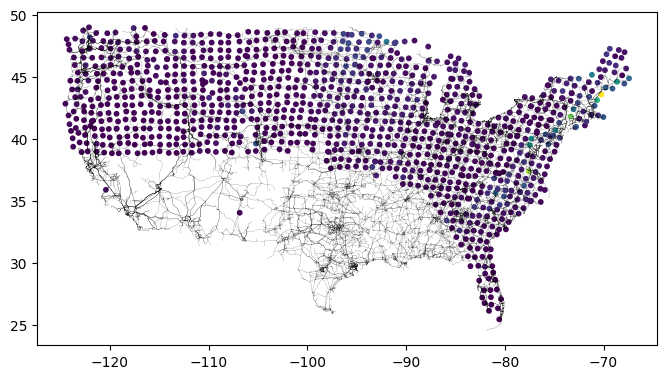

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

clipped_gdf.plot(ax=ax, linewidth=0.1, facecolor="none", edgecolor="black")
magnetotelluric_gdf.plot(ax=ax, column="E data max", cmap="viridis", markersize=10)

plt.show()

In [150]:
assert tl_filt_gdf.crs == bounding_gdf.crs